In [139]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import catboost as cb

# import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import MDS

from scipy.spatial.distance import pdist, squareform

Resources:  https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329

### Load and Clean Data

In [123]:
datapath = './data/'
df_train_features_raw = pd.read_csv(datapath+'train_values.csv').set_index('building_id')
df_train_labels_raw = pd.read_csv(datapath+'train_labels.csv').set_index('building_id')
df_test_features_raw = pd.read_csv(datapath+'test_values.csv').set_index('building_id')

- No missing data to fill

In [124]:
def preprocess(df_features):
    df_features = df_features.astype({'count_floors_pre_eq':'float',
                                      'age':'float',
                                      'area_percentage':'float',
                                      'height_percentage':'float',
                                      'count_families':'float'})
    return df_features

In [125]:
# Prep data for catboost
df_train_features = preprocess(df_train_features_raw)
X_train, X_test, y_train, y_test = train_test_split(df_train_features, df_train_labels_raw, test_size = 0.2, random_state=42)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(X_train.dtypes):
    if dtype in ['int64','object']:
        categorical_features_indices.append(i)
categorical_features = []
for colname,dtype in zip(X_train.columns,X_train.dtypes):
    if dtype in ['int64','object']:
        categorical_features.append(colname)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=X_train, label=y_train, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=X_test, label=y_test, cat_features=categorical_features_indices)

## EDA

### Geographic

In [279]:
df_train = pd.concat([df_train_features,df_train_labels_raw],axis=1)
geo_levels = ['geo_level_1_id','geo_level_2_id','geo_level_3_id']

In [280]:
df_train_geo = df_train.copy()[geo_levels+['damage_grade']]
df_train_geo.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,damage_grade
building_id,,,,
802906,6,487,12198,3
28830,8,900,2812,2
94947,21,363,8973,3
590882,22,418,10694,2
201944,11,131,1488,3


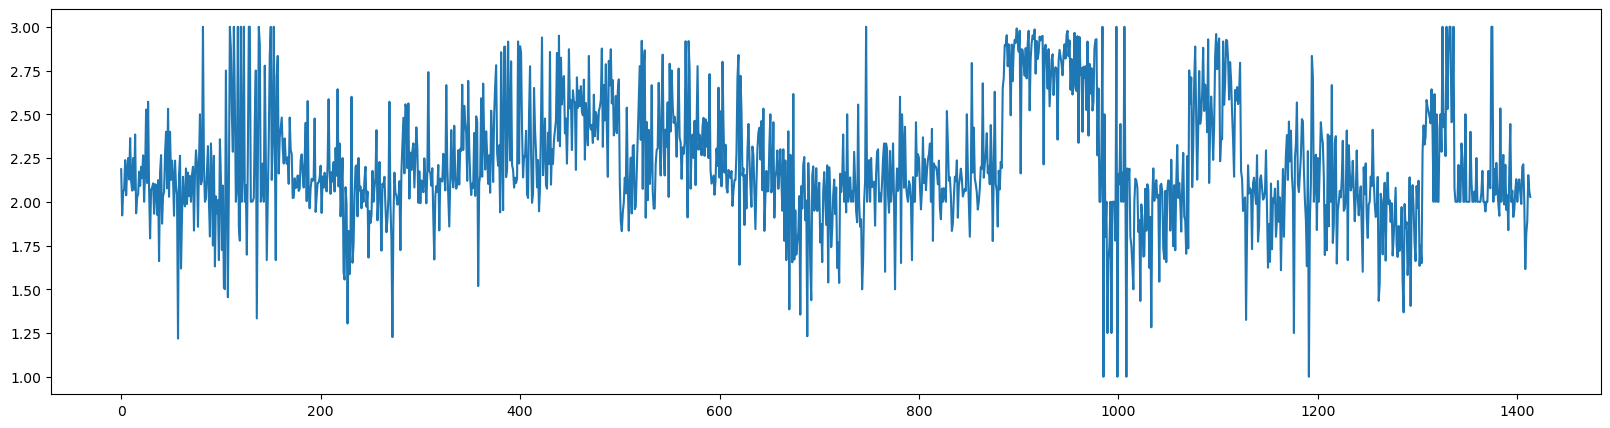

In [281]:
fig,ax = plt.subplots(1,1,figsize=(20,5))
df_geolevel2 = df_train_geo.groupby('geo_level_2_id').mean()[['damage_grade']]
df_geolevel_all = df_train_geo.groupby(['geo_level_1_id','geo_level_2_id']).mean()
sort_ind_2 = np.array([j for i,j in df_geolevel_all.index])
df_geolevel2 = df_geolevel2.loc[sort_ind_2]
df_geolevel2 = df_geolevel2.reset_index(drop=True)
ax.plot(df_geolevel2.index,np.squeeze(df_geolevel2.values))



<Axes: xlabel='index', ylabel='damage_grade'>

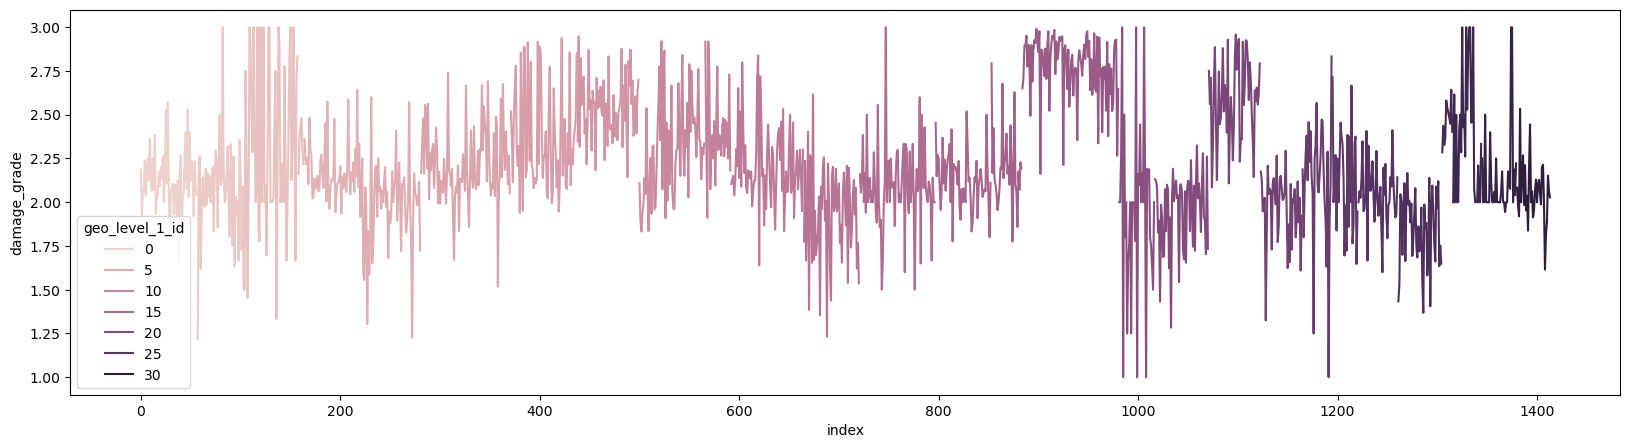

In [294]:
fig,ax = plt.subplots(1,1,figsize=(20,5))
df_geolevel_all2 = df_geolevel_all.reset_index().reset_index()
sns.lineplot(df_geolevel_all2,x='index',y='damage_grade',hue='geo_level_1_id',ax=ax)


In [296]:
df_train

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2.0,30.0,6.0,5.0,t,r,n,...,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2.0,10.0,8.0,7.0,o,r,n,...,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2.0,10.0,5.0,5.0,t,r,n,...,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2.0,10.0,6.0,5.0,t,r,n,...,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3.0,30.0,8.0,9.0,t,r,n,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,25,1335,1621,1.0,55.0,6.0,3.0,n,r,n,...,0,0,0,0,0,0,0,0,0,2
669485,17,715,2060,2.0,0.0,6.0,5.0,t,r,n,...,0,0,0,0,0,0,0,0,0,3
602512,17,51,8163,3.0,55.0,6.0,7.0,t,r,q,...,0,0,0,0,0,0,0,0,0,3


In [160]:
# One hot encode categorical columns
geo_locs = df_train_geo.drop(columns=['damage_grade'])
df_train_dummied = pd.get_dummies(df_train, columns=[cat for cat in categorical_features if not (cat in geo_levels)])

In [161]:
# Scale to keep all features between range 0,1
scaler = MinMaxScaler()
df_train_dummied_scaled = scaler.fit_transform(df_train_dummied.drop(columns=geo_levels))

In [204]:
df_train_geo_count = df_train_geo.groupby(geo_levels).count()
df_train_geo_count.rename(columns={'damage_grade':'count'},inplace=True)
df_train_geo_count

count
geo_level_1_id geo_level_2_id geo_level_3_id       
0              62             1418                2
                              3149                3
                              3181                7
                              4066                4
                              5354                6
...                                             ...
30             1391           8191                6
                              9788                6
                              10129               1
                              10950               8
                              11638               1

[11595 rows x 1 columns]

In [211]:
df_train_geo_count.loc[(0,),:].sum()

count    4011
dtype: int64

In [218]:
df_train_geo.groupby('geo_level_1_id').count()['damage_grade']

geo_level_1_id
0      4011
1      2701
2       931
3      7540
4     14568
5      2690
6     24381
7     18994
8     19080
9      3958
10    22079
11     8220
12     3194
13     9608
14     1714
15     2320
16     4332
17    21813
18     3189
19      372
20    17216
21    14889
22     6252
23     1121
24     1310
25     5624
26    22615
27    12532
28      265
29      396
30     2686
Name: damage_grade, dtype: int64

In [216]:
df_train_geo['geo_level_new'] = None

In [231]:
# Merge all in upper level 19,28,29
for ind,row in df_train_geo.iterrows():
    if row['geo_level_1_id'] in [19,28,29]:
        df_train_geo.loc[ind,'geo_level_new'] = str(row['geo_level_1_id'])

<class 'pandas.core.frame.DataFrame'>
Index: 260601 entries, 802906 to 747594
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   geo_level_1_id  260601 non-null  int64 
 1   geo_level_2_id  260601 non-null  int64 
 2   geo_level_3_id  260601 non-null  int64 
 3   damage_grade    260601 non-null  int64 
 4   geo_level_new   1033 non-null    object
dtypes: int64(4), object(1)
memory usage: 20.0+ MB


In [259]:
df_train_geo_temp = df_train_geo.copy()
df_train_geo_temp = df_train_geo_temp.loc[df_train_geo_temp['geo_level_new'].isnull()]
df_train_geo_temp = df_train_geo_temp.groupby(['geo_level_1_id','geo_level_2_id']).count()
df_train_geo_temp['large'] = 0
df_train_geo_temp['large'] = df_train_geo_temp['damage_grade'].map(lambda x: 1 if x>200 else 0)
df_train_geo_temp['large'].groupby('geo_level_1_id').count()

geo_level_1_id
0     57
1     47
2     54
3      6
4     55
5     62
6     90
7     67
8     62
9     16
10    50
11    26
12    73
13    56
14    76
15    56
16    31
17    79
18    18
20    54
21    52
22    42
23    30
24    26
25    40
26    44
27    11
30    34
Name: large, dtype: int64

In [267]:
for i in df_train.groupby('geo_level_2_id').count()['roof_type'].sort_values(ascending=False):
    print(i)

4038
2520
2080
2040
1897
1760
1740
1704
1684
1626
1537
1497
1450
1359
1145
1135
1114
1091
1090
1069
1063
1053
1043
1041
1038
1024
995
947
941
912
906
866
859
855
828
790
777
776
743
725
722
720
700
694
689
668
662
658
635
614
614
613
606
603
601
594
593
592
585
580
575
560
551
545
545
543
538
533
531
530
529
522
522
520
512
508
500
500
500
499
498
497
495
491
490
484
483
482
479
478
477
476
468
466
466
465
464
461
460
459
458
457
455
452
451
451
451
449
449
448
448
448
447
446
437
437
435
434
431
428
422
422
420
419
417
416
416
415
414
412
411
410
409
409
407
406
404
403
402
401
401
401
400
396
395
393
392
391
390
390
389
388
388
387
384
382
382
380
380
380
379
376
376
375
375
373
373
372
372
371
369
368
367
367
367
367
366
366
366
364
362
359
359
358
358
357
356
354
354
354
352
352
351
351
350
347
347
347
346
345
345
344
344
343
342
341
340
340
338
337
337
336
336
334
334
333
333
333
332
330
330
330
330
330
329
329
329
328
328
328
327
326
325
325
324
324
322
321
320
320
319
318
318
31

In [162]:
# Calculate dissimilarity matric and perform Multidimensional Scaling (MDS). Does not work, pairwise matrix too large!
mds = MDS(n_components=2, dissimilarity='euclidean', random_state=42)
X_mds = mds.fit_transform(df_train_dummied_scaled)

MemoryError: Unable to allocate 506. GiB for an array with shape (260601, 260601) and data type float64

## CatBoost Training

### First Attempt

In [45]:
# Instantiate catboost regressor model
model = cb.CatBoostRegressor(loss_function='RMSE')

# Grid search training
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

0:	learn: 2.2553502	test: 2.2560586	best: 2.2560586 (0)	total: 367ms	remaining: 36.3s
1:	learn: 2.1922772	test: 2.1929840	best: 2.1929840 (1)	total: 477ms	remaining: 23.4s
2:	learn: 2.1305542	test: 2.1312584	best: 2.1312584 (2)	total: 590ms	remaining: 19.1s
3:	learn: 2.0707731	test: 2.0716203	best: 2.0716203 (3)	total: 785ms	remaining: 18.8s
4:	learn: 2.0128228	test: 2.0136105	best: 2.0136105 (4)	total: 869ms	remaining: 16.5s
5:	learn: 1.9567082	test: 1.9576252	best: 1.9576252 (5)	total: 938ms	remaining: 14.7s
6:	learn: 1.9024358	test: 1.9034904	best: 1.9034904 (6)	total: 1s	remaining: 13.3s
7:	learn: 1.8502817	test: 1.8513965	best: 1.8513965 (7)	total: 1.07s	remaining: 12.4s
8:	learn: 1.7994752	test: 1.8006884	best: 1.8006884 (8)	total: 1.14s	remaining: 11.5s
9:	learn: 1.7502540	test: 1.7515714	best: 1.7515714 (9)	total: 1.2s	remaining: 10.8s
10:	learn: 1.7031167	test: 1.7044380	best: 1.7044380 (10)	total: 1.27s	remaining: 10.3s
11:	learn: 1.6575988	test: 1.6589211	best: 1.6589211 (11

{'params': {'depth': 8,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2,
  'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [46]:
# Evaluation
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print('Testing performance')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')

Testing performance
RMSE: 0.45
R2: 0.47


In [47]:
import pickle
with open('earthquake_cb_model_1.pkl', 'wb') as f:
    pickle.dump(model, f)

In [65]:
pred_int = np.round(pred)
# (pred_int == np.squeeze(y_test.to_numpy())).sum()/y_test.shape[0]
f1_score(y_test,pred_int,average='micro')
# f1_score(y_test,pred_int)

0.7344256633602578

<BarContainer object of 38 artists>

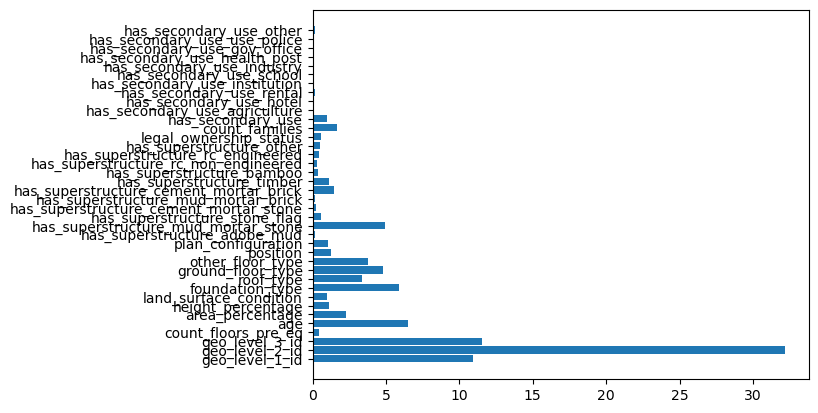

In [71]:
feature_importance_vals = model.get_feature_importance()
plt.barh(X_train.columns,feature_importance_vals)
